In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import gc

https://www.codementor.io/@dejanbatanjac/pytorch-the-missing-manual-on-loading-mnist-dataset-wjeh5top7

In [2]:
t = transforms.Compose([
                       transforms.ToTensor()])

In [3]:
mnist_dataset = torchvision.datasets.MNIST(root = '/data/mnist', train = True, transform = t, download = True)
mnist_dataset_val = torchvision.datasets.MNIST(root = '/data/mnist', train = False, transform = t, download = True)


In [4]:
from torch.utils.data import DataLoader, Dataset
import random

In [5]:
class Mnist_Rand_Number(Dataset):
    def __init__(self, mnist_builtin):
        self.mnist_builtin = mnist_builtin

    def __getitem__(self, index):
        image,label = self.mnist_builtin[index]
        return image,label,random.randint(0,9)

    def __len__(self):
        return len(self.mnist_builtin)

In [6]:
mnist_number_dataset = Mnist_Rand_Number(mnist_dataset)

In [7]:
mnist_number_dataset_val = Mnist_Rand_Number(mnist_dataset_val)

In [8]:
mnist_number_loader = DataLoader(mnist_number_dataset,32,True)

In [9]:
mnist_number_loader_val = DataLoader(mnist_number_dataset_val,32,False)

In [10]:
# batch_images,batch_labels,batch_randomn_numbers = next(iter(mnist_number_loader))

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)    # 1x28x28
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)   # 8x26x26
        # maxpool                                                               # 16x24x24
        self.fc1 = nn.Linear(in_features=16 * 12 * 12, out_features=120)        # 16x12x12
        self.fc2 = nn.Linear(in_features=120, out_features=60)                  # 1x120
        self.out1 = nn.Linear(in_features=60, out_features=10)                  # 1x60
                                                                                # 1x10
        self.out2 = nn.Linear(in_features=60 + 10, out_features=19)             # 1x60
                                                                                # 1x19
    def forward(self,img,rnum):
        x = self.conv1(img)

        x = self.conv2(F.relu(x))
        x = F.max_pool2d(F.relu(x), kernel_size=2, stride=2)
        x = F.relu(x).flatten(start_dim=1, end_dim=-1)
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        y1 = self.out1(F.relu(x))
        y2 = self.out2(torch.cat([F.relu(x),torch.nn.functional.one_hot(torch.tensor(rnum),10)],dim = 1))
        return torch.cat([F.log_softmax(y1,dim = 1),F.log_softmax(y2,dim = 1)],dim = 1)

In [13]:
net = Network()

In [14]:
# temp = net(batch_images,batch_randomn_numbers)

In [15]:
# temp.shape

In [16]:
# batch_randomn_numbers.unsqueeze(dim = 1).shape

In [17]:
# batch_labels.shape,batch_randomn_numbers.shape

In [18]:
# torch.cat([batch_labels.unsqueeze(dim = 1),batch_randomn_numbers.unsqueeze(dim = 1)],dim = 1).shape

In [19]:
# loss_1 = torch.nn.NLLLoss()(temp[:,:10], batch_labels)

In [20]:
# loss_2 = torch.nn.NLLLoss()(temp[:,10:], batch_randomn_numbers)

In [21]:
# final_loss = loss_1 + loss_2

In [22]:
import torch.optim as optim
# optimizer = optim.Adam(net.parameters(), lr=0.01)

In [23]:
# final_loss.backward()
# optimizer.step()

In [24]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [25]:
dev

device(type='cuda')

In [26]:
# for batch in train_loader: # Get Batch
#     batch_images,batch_labels,batch_randomn_numbers = batch 
#     batch_images,batch_labels,batch_randomn_numbers = batch_images.to(dev),batch_labels.to(dev),batch_randomn_numbers.to(dev)
#     break

In [27]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [28]:
net = net.to(dev)
train_loader = mnist_number_loader
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_mnist_loss_tracker = []
train_randomn_loss_tracker = []
test_mnist_loss_tracker = []
test_randomn_loss_tracker = []
train_mnist_accuracy_tracker = []
train_randomn_accuracy_tracker = []
test_mnist_accuracy_tracker = []
test_randomn_accuracy_tracker = []
for epoch in range(20):

    total_loss = 0
    total_correct_mnist = 0
    total_correct_randomn = 0
    total_samples = 0
    train_mnist_loss = 0
    train_randomn_loss = 0
    net = net.train()
    for batch in train_loader: # Get Batch
        batch_images,batch_labels,batch_randomn_numbers = batch 
        batch_images,batch_labels,batch_randomn_numbers = batch_images.to(dev),batch_labels.to(dev),batch_randomn_numbers.to(dev)
        preds = net(batch_images,batch_randomn_numbers) # Pass Batch
        loss_1 = torch.nn.NLLLoss()(preds[:,:10], batch_labels) # Calculate Loss
        loss_2 = torch.nn.NLLLoss()(preds[:,10:], batch_randomn_numbers+batch_labels)
        final_loss = loss_1 + loss_2
        train_mnist_loss += loss_1.item()
        train_randomn_loss += loss_2.item()
        optimizer.zero_grad()
        final_loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += final_loss.item()
        total_correct_mnist += get_num_correct(preds[:,:10], batch_labels)
        total_correct_randomn += get_num_correct(preds[:,10:], batch_randomn_numbers+batch_labels)
        total_samples += batch_labels.shape[0]
    train_mnist_loss_tracker.append(train_mnist_loss)
    train_randomn_loss_tracker.append(train_randomn_loss)
    train_mnist_accuracy_tracker.append(total_correct_mnist/total_samples)
    train_randomn_accuracy_tracker.append(total_correct_randomn/total_samples)
    total_loss = 0
    total_correct_mnist = 0
    total_correct_randomn = 0
    total_samples = 0
    test_mnist_loss = 0
    test_randomn_loss = 0
    net = net.eval()
    for batch in mnist_number_loader_val:
        gc.collect()
        batch_images,batch_labels,batch_randomn_numbers = batch 
        batch_images,batch_labels,batch_randomn_numbers = batch_images.to(dev),batch_labels.to(dev),batch_randomn_numbers.to(dev)
        preds = net(batch_images,batch_randomn_numbers)
        loss_1 = torch.nn.NLLLoss()(preds[:,:10], batch_labels) # Calculate Loss
        loss_2 = torch.nn.NLLLoss()(preds[:,10:], batch_randomn_numbers+batch_labels)
        total_loss += final_loss.item()
        test_mnist_loss += loss_1.item()
        test_randomn_loss += loss_2.item()
        total_correct_mnist += get_num_correct(preds[:,:10], batch_labels)
        total_correct_randomn += get_num_correct(preds[:,10:], batch_randomn_numbers+batch_labels)
        total_samples += batch_labels.shape[0]
    test_mnist_loss_tracker.append(test_mnist_loss)
    test_randomn_loss_tracker.append(test_randomn_loss)
    test_mnist_accuracy_tracker.append(total_correct_mnist/total_samples)
    test_randomn_accuracy_tracker.append(total_correct_randomn/total_samples)
    print(
        "epoch", epoch, 
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19


In [29]:
import matplotlib.pyplot as plt

In [52]:
max(test_randomn_accuracy_tracker)

0.7737

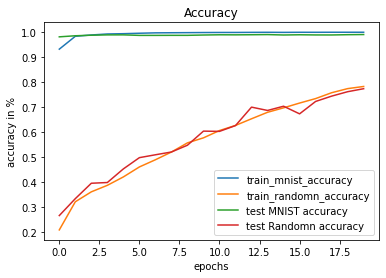

In [30]:
plt.plot(train_mnist_accuracy_tracker, label = "train_mnist_accuracy")
plt.plot(train_randomn_accuracy_tracker, label = "train_randomn_accuracy")
plt.plot(test_mnist_accuracy_tracker, label = "test MNIST accuracy")
plt.plot(test_randomn_accuracy_tracker, label = "test Randomn accuracy")
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('accuracy in %')
# giving a title to my graph
plt.title('Accuracy')
  
# show a legend on the plot
plt.legend()
plt.show()

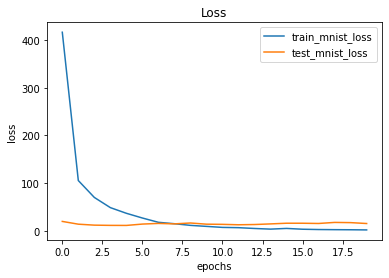

In [31]:
plt.plot(train_mnist_loss_tracker, label = "train_mnist_loss")
# plt.plot(train_randomn_loss_tracker, label = "train_randomn_loss")
plt.plot(test_mnist_loss_tracker, label = "test_mnist_loss")
# plt.plot(test_randomn_loss_tracker, label = "test_randomn_loss")
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('loss')
# giving a title to my graph
plt.title('Loss')
plt.legend()
plt.show()

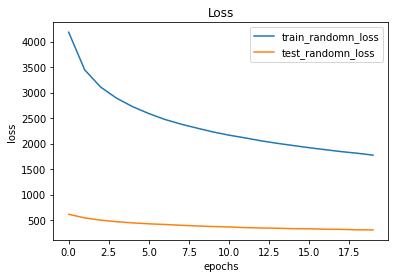

In [32]:
# plt.plot(train_mnist_loss_tracker, label = "train_mnist_loss")
plt.plot(train_randomn_loss_tracker, label = "train_randomn_loss")
# plt.plot(test_mnist_loss_tracker, label = "test_mnist_loss")
plt.plot(test_randomn_loss_tracker, label = "test_randomn_loss")
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('loss')
# giving a title to my graph
plt.title('Loss')
plt.legend()
plt.show()

In [33]:
# get_num_correct(predicted_mnist,batch_labels)

In [34]:
# batch_images,batch_labels,batch_randomn_numbers

In [35]:
# predicted_mnist = net(batch_images,batch_randomn_numbers)[:,:10]

In [36]:
# predicted_mnist.argmax(dim = 1)

In [37]:
# batch_labels

In [38]:
# predicted_radomn = net(batch_images,batch_randomn_numbers)[:,10:]

In [39]:
# predicted_radomn.argmax(dim = 1)

In [40]:
# batch_randomn_numbers

In [41]:
# mnist_number_dataset[0][0].unsqueeze(1).shape

In [42]:
# torch.tensor(mnist_number_dataset[0][2]).unsqueeze(0)

In [43]:
# torch.tensor(mnist_number_dataset[0][2]).unsqueeze(0)

In [44]:
# single_data_point = mnist_number_dataset[0]
# single_data_point[1:]

In [45]:
# predicted_mnist = net(single_data_point[0].unsqueeze(1).to(dev),torch.tensor(single_data_point[2]).unsqueeze(0).to(dev))[:,:10]

In [46]:
# predicted_mnist.argmax(dim = 1)

In [47]:
# predicted_radomn =net(single_data_point[0].unsqueeze(1).to(dev),torch.tensor(single_data_point[2]).unsqueeze(0).to(dev))[:,10:]

In [48]:
# predicted_radomn.argmax(dim = 1)